# Практическая работа 7. Перекрестная проверка

**Задача: "Распознавание цифр с использованием сверточных нейронных сетей и
перекрестной проверки"**

**Описание задачи: Решить задачу распознавания рукописных цифр на изображениях с
использованием сверточных нейронных сетей (CNN) и применить технику перекрестной
проверки для оценки обобщающей способности модели.**

Итак, мой рекорд без Pooling и библиотек, которые упростят работу равен около

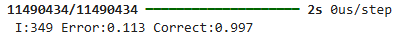

Свой код без основных библиотек я покажу как **1 способ**

Планирую визуализировать интенсивность пикселей, через метод RandomForestClassifier() для извлечения важности признаков (feature importances)


**2 способ.** Использовать tensorflow и собрать обычную CNN, поиграться с функциями активации и применить shaffle(возможно в обучении мы не увидим выбросы и на test мы увидим точность 100)

**3 способ.** Использовать предобученную модель

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


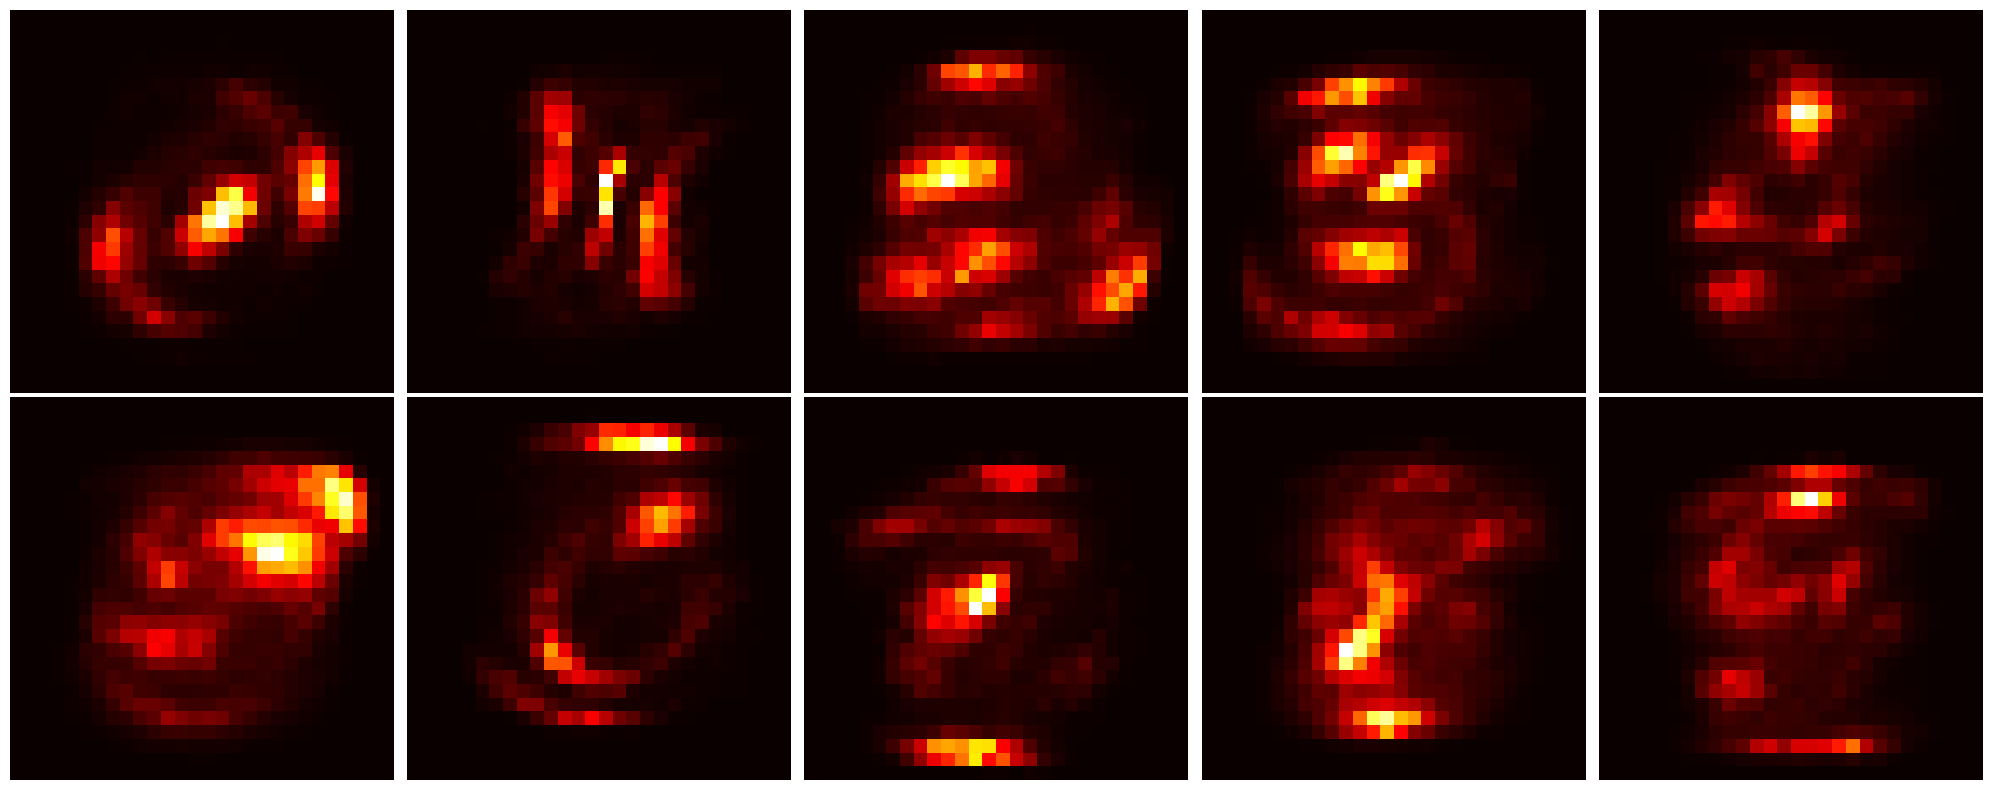

In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.ensemble import RandomForestClassifier

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = x_train.reshape((60000, 784))

res = []

def visualize_images(importances):
    plt.figure(figsize=(20, 8))

    for i, image in enumerate(importances):
        plt.subplot(2, 5, i + 1)
        plt.imshow(image, cmap="hot")
        plt.axis('off')

    plt.tight_layout(pad=1.0)
    plt.show()

def train_and_visualize_digit(digit):
    y = (y_train == digit).astype(int)

    rnd_clf = RandomForestClassifier(n_estimators=322, n_jobs=-1)
    rnd_clf.fit(x, y)

    feature_importances = rnd_clf.feature_importances_

    feature_importances_2d = feature_importances.reshape((28, 28))

    res.append(feature_importances_2d)

for digit in range(10):
    train_and_visualize_digit(digit)

visualize_images(res)

# 1 Способ

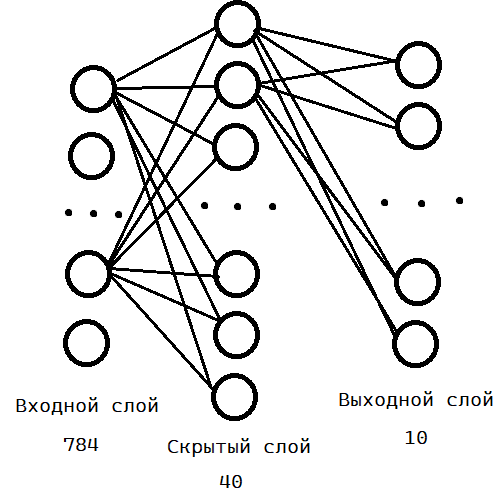

In [ ]:
import sys, numpy as np
from keras.datasets import mnist
# Загрузим ещё раз
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем данные для модели
images, labels = (x_train[0:1000].reshape(1000,28*28) / 255, y_train[0:1000])

# one_hot_labels, для выхода [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
one_hot_labels = np.zeros((len(labels), 10))

for i,l in enumerate(labels):
  one_hot_labels[i][l] = 1

labels = one_hot_labels

# Деление на 255 нормализует эти значения, приводя их к диапазону от 0 до 1.
test_images = x_test.reshape(len(x_test),28*28) / 255
test_labels = np.zeros((len(y_test),10))

for i,l in enumerate(y_test):
  test_labels[i][l] = 1

np.random.seed(42)

# Применяется обычный Relu, можно поиграть
relu = lambda x:(x>=0) * x
# Производная, для обратного распространения(backpropagation)
relu2deriv = lambda x: x>=0

# Параметры модели соответственно
# скорость обучения, количество итераций, размер скрытого слоя, количество пикселей в изображении(вход) и количество меток
alpha, iterations, hidden_size, pixels_per_image, num_labels = \
(0.005, 350, 40, 784, 10)
weights_0_l = 0.2*np.random.random((pixels_per_image,hidden_size)) - 0.1
weights_l_2 = 0.2*np.random.random((hidden_size,num_labels)) - 0.1

for j in range(iterations):
  error, correct_cnt = (0.0, 0)
  for i in range(len(images)):
    # Первый слой
    layer_0 = images[i:i+1]
    # Скрытый слой
    layer_l = relu(np.dot(layer_0,weights_0_l))
    # Выходной слой
    layer_2 = np.dot(layer_l,weights_l_2)
    # Далее вычисление ошибки и обновление весов
    error += np.sum((labels[i:i+1] - layer_2) ** 2)
    correct_cnt += int(np.argmax(layer_2) == \
    np.argmax(labels[i:i+1]))
    layer_2_delta = (labels[i:i+1] - layer_2)
    layer_l_delta = layer_2_delta.dot(weights_l_2.T)\
    * relu2deriv(layer_l)
    weights_l_2 += alpha * layer_l.T.dot(layer_2_delta)
    weights_0_l += alpha * layer_0.T.dot(layer_l_delta)

  sys.stdout.write("\r"+ " I:"+str(j)+ \
" Error:" + str(error/float(len(images)))[0:5] +\
" Correct:" + str(correct_cnt/float(len(images))))

 I:349 Error:0.107 Correct:0.999

Ух ты! Побит рекорд! Можно и заканчивать тетрадь, но нет 😀!

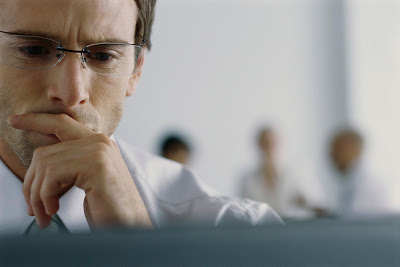

# 2 Способ

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score

In [ ]:
# Загрузка данных MNIST
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Преобразование данных для работы с CNN
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1)).astype('float32') / 255
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1)).astype('float32') / 255

# Преобразование меток в one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

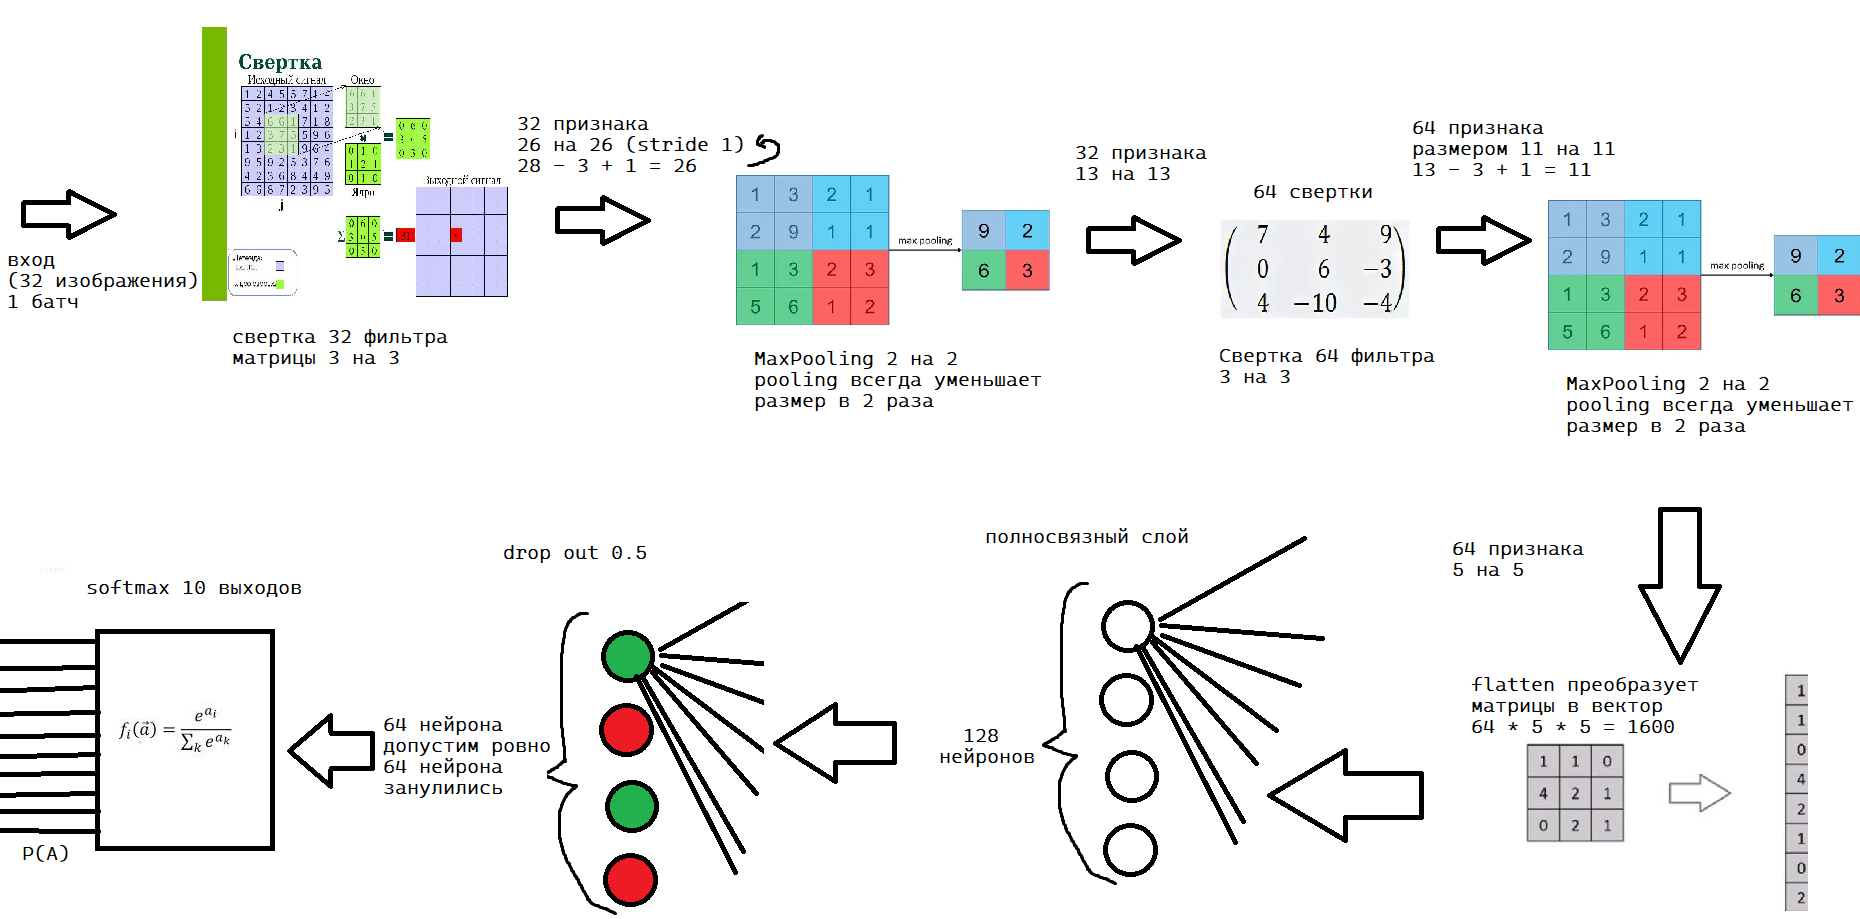

In [ ]:
def create_model(input_shape, num_classes, activation='relu'):
    model = Sequential()
    # 32 фильтра размером 3x3 к входному изображению
    model.add(Conv2D(32, (3, 3), activation=activation, input_shape=input_shape))
    # уменьшает размерность каждой карты признаков в два раза, выбирая максимальное значение в каждом окне 2x2
    model.add(MaxPooling2D((2, 2)))
    # Этот слой применяет 64 фильтра размером 3x3 к каждой из 32 карт признаков
    model.add(Conv2D(64, (3, 3), activation=activation))
    # уменьшает размерность каждой карты признаков в два раза, выбирая максимальное значение в каждом окне 2x2
    model.add(MaxPooling2D((2, 2)))
    # преобразует многомерные данные (64 карты признаков размером 5x5) в одномерный вектор
    # Слой выравнивания
    model.add(Flatten())
    # Полносвязный слой
    model.add(Dense(128, activation=activation))
    # случайным образом отключает 50% нейронов на каждом шаге обучения
    model.add(Dropout(0.5))
    # линейное преобразование данных, полученных после слоя Dropout, и применяет функцию активации softmax
    model.add(Dense(num_classes, activation='softmax'))

    return model

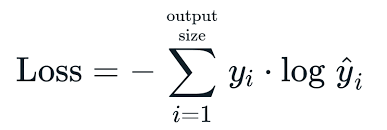

In [ ]:
# Перемешать данные
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]

# Перекрестная проверка
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cvscores = []

for train, test in kfold.split(X_train, y_train):
    model = create_model(input_shape=(28, 28, 1), num_classes=10, activation='relu')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Обучение модели
    model.fit(X_train[train], y_train[train], epochs=9, batch_size=32, validation_data=(X_train[test], y_train[test]))

    # Оценка модели
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    cvscores.append(scores[1] * 100)

print(f"Cross-Validation Accuracy: {np.mean(cvscores):.2f}% (+/- {np.std(cvscores):.2f}%)")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/9
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 53s 34ms/step - accuracy: 0.8586 - loss: 0.4520 - val_accuracy: 0.9786 - val_loss: 0.0735
Epoch 2/9
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 81s 34ms/step - accuracy: 0.9743 - loss: 0.0834 - val_accuracy: 0.9843 - val_loss: 0.0495
Epoch 3/9
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - accuracy: 0.9824 - loss: 0.0588 - val_accuracy: 0.9862 - val_loss: 0.0453
Epoch 4/9
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - accuracy: 0.9858 - loss: 0.0462 - val_accuracy: 0.9878 - val_loss: 0.0406
Epoch 5/9
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 49s 33ms/step - accuracy: 0.9864 - loss: 0.0415 - val_accuracy: 0.9867 - val_loss: 0.0429
Epoch 6/9
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 81s 32ms/step - accuracy: 0.9880 - loss: 0.0382 - val_accuracy: 0.9902 - val_loss: 0.0371
Epoch 7/9
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 85s 34ms/step - accuracy: 0.9897 - loss: 0.0332 - val_accuracy: 0.9895 - val_loss: 0.0414
Epoch 8/9
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 81s 34ms/step - accuracy: 0.9917 - loss: 0

После 9 эпохи явное переобучение

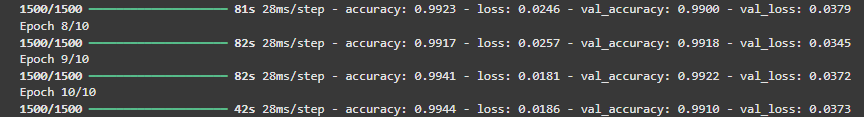

In [ ]:
# Создание и компиляция модели
final_model = create_model(input_shape=(28, 28, 1), num_classes=10, activation='relu')
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели на всех данных
history = final_model.fit(X_train, y_train, epochs=9, batch_size=32, validation_split=0.2)

# Оценка модели на тестовой выборке
test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Epoch 1/9
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.8564 - loss: 0.4576 - val_accuracy: 0.9771 - val_loss: 0.0764
Epoch 2/9
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 81s 33ms/step - accuracy: 0.9735 - loss: 0.0930 - val_accuracy: 0.9860 - val_loss: 0.0478
Epoch 3/9
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 83s 34ms/step - accuracy: 0.9817 - loss: 0.0616 - val_accuracy: 0.9870 - val_loss: 0.0442
Epoch 4/9
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - accuracy: 0.9844 - loss: 0.0508 - val_accuracy: 0.9877 - val_loss: 0.0419
Epoch 5/9
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - accuracy: 0.9874 - loss: 0.0401 - val_accuracy: 0.9892 - val_loss: 0.0394
Epoch 6/9
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 80s 33ms/step - accuracy: 0.9897 - loss: 0.0331 - val_accuracy: 0.9889 - val_loss: 0.0420
Epoch 7/9
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 83s 34ms/step - accuracy: 0.9899 - loss: 0.0307 - val_accuracy: 0.9886 - val_loss: 0.0424
Epoch 8/9
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - accuracy: 0.9914 - loss: 0

In [ ]:
history.history['accuracy']

[0.9314791560173035,
 0.9748749732971191,
 0.9814375042915344,
 0.984541654586792,
 0.9866874814033508,
 0.989187479019165,
 0.9898541569709778,
 0.9912083148956299,
 0.992562472820282]

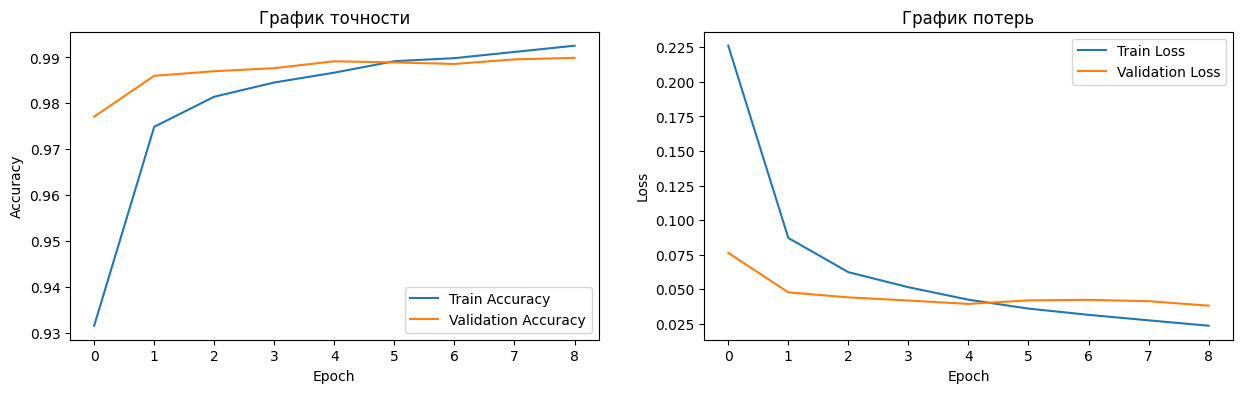

In [ ]:
plt.figure(figsize=(15, 4))

# График точности
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('График точности')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# График потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('График потерь')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

# 3 Способ

Использование предобученной модели VGG16, и адаптация её для работы с MNIST

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Преобразование данных для работы с VGG16
X_train = np.stack((X_train,)*3, axis=-1)  # Преобразование в 3 канала
X_test = np.stack((X_test,)*3, axis=-1)    # Преобразование в 3 канала

# Нормализация данных
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Преобразование меток в one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Загрузка предобученной модели VGG16 без верхних слоев
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Добавление новых слоев для классификации MNIST
model = Sequential()
model.add(tf.keras.layers.UpSampling2D(size=(8, 8), interpolation='bilinear'))  # Увеличение размера изображений до 224x224
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Компиляция модели
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(X_train, y_train, epochs=9, batch_size=32, validation_split=0.2)

# Оценка модели на тестовой выборке
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Визуализация процесса обучения
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# График точности
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('График точности')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# График потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('График потерь')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

Epoch 1/9
 171/1500 ━━━━━━━━━━━━━━━━━━━━ 24:49:47 67s/step - accuracy: 0.1051 - loss: 3.2527

KeyboardInterrupt: 

Спустя 4-5 часов работы мы не прошли даже 1 эпоху и сделали 171 итерацию, можно было бы уменьшить batch-size, но по истории обучения можно заметить очень долгую сходимость модели. Следовательно, данная модель слишком сложная для mnist. К тому же мы применяем UpSampling, и увеличиваем очень сильно размер изображений в батче примерно в x10 раз